<a href="https://colab.research.google.com/github/lszam/potentials-on/blob/main/PosdocON_GravCamposSantosRibeira_Etapa02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ambiente**

##Bibliotecas

In [1]:
!pip install geopandas shapely matplotlib zipfile36 verde -q

import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import shutil
import verde as vd
import requests

from shapely.geometry import Polygon


In [2]:
!pip install pystac-client pyproj rasterio -q

In [3]:
import pystac_client
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from shapely.geometry import shape, Polygon, mapping

from pyproj import Transformer, CRS

import rasterio
from rasterio.plot import show
from rasterio.mask import mask

In [4]:
!apt-get install -y gdal-bin python3-gdal
!gdalinfo --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.8.4+dfsg-1~jammy0).
python3-gdal is already the newest version (3.8.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
GDAL 3.8.4, released 2024/02/08


In [5]:
!pip install planetary_computer -q

In [6]:
!pip install cmocean -q

In [7]:
import cmocean

###### Função para plotar 2 mapas do Brasil

In [8]:
def plot_2maps(gdf1, title1, color1, gdf2, title2, color2, brasil_contour):
    """
    Função para plotar dois mapas do Brasil, para situações onde seja necessário comparar dados.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 2 subplots

    # Mapa de pontos que vão ser considerados no projeto
    brasil_contour.plot(ax=axes[0], color='none', edgecolor='black')
    gdf1.plot(ax=axes[0], color=color1, markersize=0.2, alpha=0.6)
    axes[0].set_title(title1, fontsize=16)
    axes[0].set_xlabel('Longitude', fontsize=14)
    axes[0].set_ylabel('Latitude', fontsize=14)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].grid(True)

    # Mapa com pontos duplicados, que serão retirados
    brasil_contour.plot(ax=axes[1], color='none', edgecolor='black')
    gdf2.plot(ax=axes[1], color=color2, markersize=0.2, alpha=0.6)
    axes[1].set_title(title2, fontsize=16)
    axes[1].set_xlabel('Longitude', fontsize=14)
    axes[1].set_ylabel('Latitude', fontsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

###### Função para dados espúrios. Correção de caracteres fora do esperado (pontuação de milhar, vírgula, etc).

In [9]:
def correct_grav_obs_value(value):
    """
    Função para corrigir valores da coluna GRAV_OBS:
    - Remove múltiplos pontos, mantendo apenas o último
    - Substitui vírgulas por pontos
    - Remove caracteres não numéricos
    """
    if pd.isnull(value):
        return value  # Retorna o valor original se for NaN

    # Garantir que o valor é uma string e remover espaços extras
    value = str(value).strip()

    # Substituir vírgulas por pontos
    value = value.replace(',', '.')

    # Se o valor não for uma string válida, retornar None
    if not isinstance(value, str) or value == '':
        return None

    # Corrigir múltiplos pontos, mantendo apenas o último
    if value.count('.') > 1:
        parts = value.split('.')
        value = ''.join(parts[:-1]) + '.' + parts[-1]

    # Converter para float, se possível
    try:
        return float(value)
    except ValueError:
        print ('Erro ao corrigir:', value)
        return None

###### Haversine - distância em coordenadas lat long.

A fórmula Haversine pode ser usada para calcular a distância na esfera. Ela considera a curvatura da terra, mas pressupõe uma terra esférica em vez de um elipsoide. Para longas distâncias, a fórmula Haversine introduz um erro de menos de 0,1%. A altitude não é usada para calcular a distância. Mais em Microsoft Learn https://learn.microsoft.com/pt-br/dotnet/api/system.device.location.geocoordinate.getdistanceto?view=netframework-4.8.1

In [10]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calcula a distância entre dois pontos em km usando a fórmula de Haversine.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # Raio médio da Terra em km
    return km

###### Função para encontrar pontos dentro de uma janela de raio específico

In [11]:
# Função para encontrar pontos dentro de uma janela de raio específico
def find_neighbors(gdf, index, window_size_km):
    """Encontra todos os pontos dentro de uma janela de raio específico em km."""
    lon, lat = gdf.loc[index, ['LONGITUDE', 'LATITUDE']]
    distances = gdf.apply(lambda row: haversine(lon, lat, row['LONGITUDE'], row['LATITUDE']), axis=1)
    neighbors = gdf[distances <= window_size_km]
    return neighbors

## Configurar área de estudo

Sistema de coordenadas personalizado - policônica com datum sirgas 2000 (EPSG ?)

In [12]:
from pyproj import CRS

# String do .prj
wkt_string = '''PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]'''

# Criar o objeto CRS a partir do WKT
crs_projeto = CRS.from_wkt(wkt_string)

# Verificar o CRS
print(crs_projeto)

PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


In [13]:
shapefile_path = "janela-ptrII_pg.shp"

#Criar polígono do entorno
aoi_gdf = gpd.read_file(shapefile_path)
aoi_gdf['geometry'] = aoi_gdf['geometry'].buffer(0) # corrige geometrias inválidas com buffer(0)
aoi_gdf = aoi_gdf[aoi_gdf.is_valid & (~aoi_gdf.is_empty)] # apagar feições que ainda estão inválidas

# Verificar CRS
if aoi_gdf.crs is None:
    aoi_gdf = aoi_gdf.set_crs(epsg=crs_projeto)
    print(f"CRS vazio. Definido {crs_projeto}.")
else:
    print(f"CRS original: {aoi_gdf.crs}")
    if aoi_gdf.crs.to_epsg() != crs_projeto:
        aoi_gdf = aoi_gdf.to_crs(epsg=crs_projeto)
        print("Reprojetado.")

CRS original: PROJCS["Polyconic_Brasil",GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Polyconic"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-54],PARAMETER["false_easting",5000000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


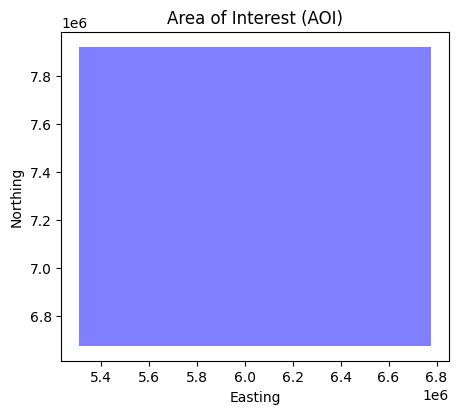

In [14]:
# Obter limites e montar objeto geoJSON
minx, miny, maxx, maxy = aoi_gdf.total_bounds
coords = [
    [minx, miny],
    [maxx, miny],
    [maxx, maxy],
    [minx, maxy],
    [minx, miny]   # fecha o poligono
]

aoi = {
    "type": "Polygon",
    "coordinates": [coords]
}

# Criar um polígono do entorno e exibir
aoi_polygon = Polygon(aoi['coordinates'][0])
aoi_gdf = gpd.GeoDataFrame(index=[0], geometry=[aoi_polygon])
aoi_gdf = aoi_gdf.set_crs(crs_projeto, inplace=True)

fig, ax = plt.subplots(figsize=(5, 5))
aoi_gdf.plot(ax=ax, color='blue', alpha=0.5)
ax.set_title('Area of Interest (AOI)')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
plt.show()

**Upload dos dados preparados na Etapa 1**

In [15]:
grav_gdf = gpd.read_file("grav_gdf_copernicus.gpkg")
print(grav_gdf.head())

    LATITUDE  LONGITUDE   GRAV_OBS  ALT_ORT                source_file  \
0 -11.186133 -62.155065  978167.79   238.14  /content/bgi_20250221.zip   
1 -11.195567 -62.155110  978167.09   232.07  /content/bgi_20250221.zip   
2 -11.205559 -62.154960  978168.31   214.83  /content/bgi_20250221.zip   
3 -11.214858 -62.155118  978163.82   240.39  /content/bgi_20250221.zip   
4 -11.221462 -62.161604  978165.31   218.33  /content/bgi_20250221.zip   

   ALT_ORTCO                     geometry  
0        NaN  POINT (-62.15507 -11.18613)  
1        NaN  POINT (-62.15511 -11.19557)  
2        NaN  POINT (-62.15496 -11.20556)  
3        NaN  POINT (-62.15512 -11.21486)  
4        NaN   POINT (-62.1616 -11.22146)  


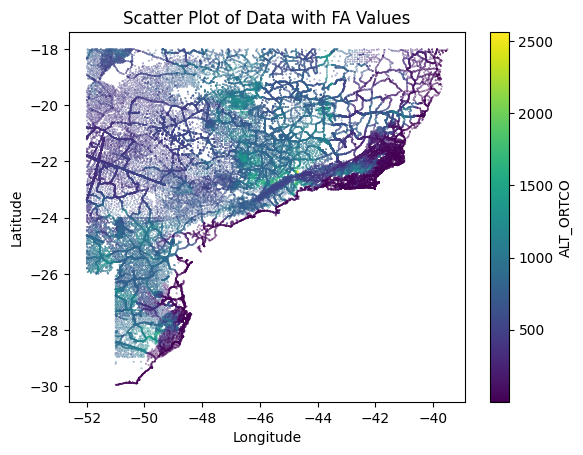

In [16]:
#aoi_gdf.plot(ax=ax, color='blue', alpha=0.1)
grav_gdf.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', c='ALT_ORTCO', cmap='viridis', s=0.05, title='Scatter Plot of Data with FA Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.grid(True)
plt.show()

In [17]:
print(f"Número de registros em grav_gdf é: {len(grav_gdf)}")

Número de registros em grav_gdf é: 237893


# **2. Redução dos dados**


##**2.1 Anomalia Ar-livre**

**Com o uso do Copernicus, não há o cálculo utilizando o geóide.**
O MDE COP-30 está referenciado em coordenadas geográficas WGS84 (datum horizontal) e altitude ortométrica referenciada ao modelo geoidal EGM2008 (datum vertical).

###### **Altitude ortométrica (H)**

In [18]:
!pip install cmocean -q

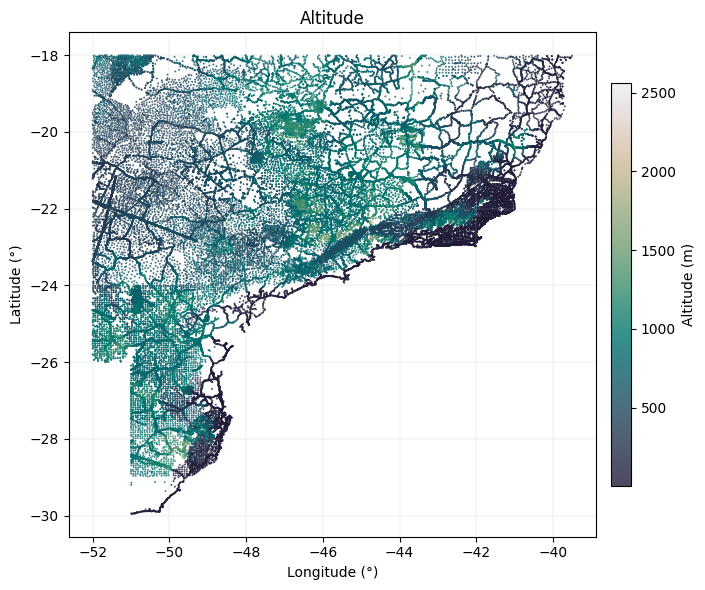

In [19]:
# Filtrar apenas registros com ALT_ORTCO numérico
mask = np.isfinite(grav_gdf["ALT_ORTCO"])
grav_gdf_plot = grav_gdf.loc[mask]

# Extrair coordenadas e valores
x = grav_gdf_plot.geometry.x.values
y = grav_gdf_plot.geometry.y.values
cop = grav_gdf_plot["ALT_ORTCO"].values  # altitude em metros

# Plot
import cmocean
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(
    x, y,
    c=cop,
    cmap=cmocean.cm.rain_r,
    s=2,
    alpha=0.8,
    linewidth=0
)

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("Altitude")

# Manter proporção ~ 1:1 nos eixos
ax.set_aspect("equal", adjustable="box")

# Barra de cores
cbar = fig.colorbar(sc, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label("Altitude (m)")

plt.grid(True, linewidth=0.3, alpha=0.5)
plt.tight_layout()

## **2.2 Ar-livre terrestre e ar-livre Sandwell offshore**

Gravidade normal - pode ser descrita como

*γ = γe (1 + β sin²φ) + termos de ordem superior*

sendo γ a gravidade normal, γe a gravidade normal no equador, β um parâmetro que depende da forma da Terra e φ é a latitude.

Formula internacinal da gravidade 1967:

𝛾67 = 978031,8  *  1+0,0053024sin²𝜑 −0,0000059sin²2𝜑   

Alternativa

𝛾 =978031,846  *  1+0,005278895sin²𝜑 +0,000023462sin^4𝜑    

In [20]:
# Calculo da Gravidade normal em mGal (GRS-80)
phi = np.deg2rad(grav_gdf.loc[mask, "LATITUDE"])
g_norm = 978031.846 * ( 1 + 0.005278895 * np.sin(phi)**2 - 0.000023462 * np.sin(phi)**4)

In [21]:
# Altitude ortométrica H (m)
H = grav_gdf.loc[mask, "ALT_ORTCO"]

In [22]:
# Correção free-air: ΔgFA = 0.3086·H − 3.1·10⁻⁶·H²
FA = 0.3086 * H - 3.1e-6 * H**2

In [23]:
# Anomalia free-air δgFA = g_obs − g_norm + ΔgFA
dg_FA = grav_gdf.loc[mask, "GRAV_OBS"] - g_norm + FA

In [24]:
# Adicionar colunas ao GeoDataFrame
grav_gdf.loc[mask, "FA_CORR"] = FA
grav_gdf.loc[mask, "FA"] = dg_FA
grav_gdf_terra = grav_gdf.loc[mask, ["LATITUDE","LONGITUDE","GRAV_OBS", "ALT_ORTCO","FA_CORR","FA", "geometry"]]

# Salvar backup
from google.colab import files
grav_gdf_terra.to_file("/content/grav_fa_onshore.gpkg", driver="GPKG")
files.download('/content/grav_fa_onshore.gpkg')

grav_gdf_terra

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,LATITUDE,LONGITUDE,GRAV_OBS,ALT_ORTCO,FA_CORR,FA,geometry
1208,-26.726082,-49.484579,978933.06,518.086182,159.049316,16.983716,POINT (-49.48458 -26.72608)
1209,-26.733934,-49.478549,978933.21,522.671387,160.449524,17.966412,POINT (-49.47855 -26.73393)
1210,-26.744365,-49.478098,978934.66,520.868408,159.898941,18.111881,POINT (-49.4781 -26.74436)
1211,-26.752794,-49.473389,978937.82,517.515625,158.875076,19.638548,POINT (-49.47339 -26.75279)
1212,-26.757917,-49.464726,978938.57,517.563477,158.889694,20.032732,POINT (-49.46473 -26.75792)
...,...,...,...,...,...,...,...
237888,-22.740000,-45.130000,978610.27,531.440735,163.127075,-29.385886,POINT (-45.1337 -22.7446)
237889,-22.770000,-45.150000,978612.64,537.578491,165.000854,-27.068004,POINT (-45.1492 -22.7687)
237890,-22.780000,-45.160000,978615.91,545.278625,167.351273,-22.089991,POINT (-45.1598 -22.7822)
237891,-22.800000,-45.170000,978623.15,541.261047,166.124969,-17.361760,POINT (-45.1732 -22.805)


In [25]:
# Salvar grav_gdf_terra como shapefile
base = '/content/grav_gdf_terra'
grav_gdf_terra.to_file(f'{base}.shp')
for ext in ('shp','shx','dbf','prj'):
    path = f'{base}.{ext}'
    if os.path.exists(path):
      files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

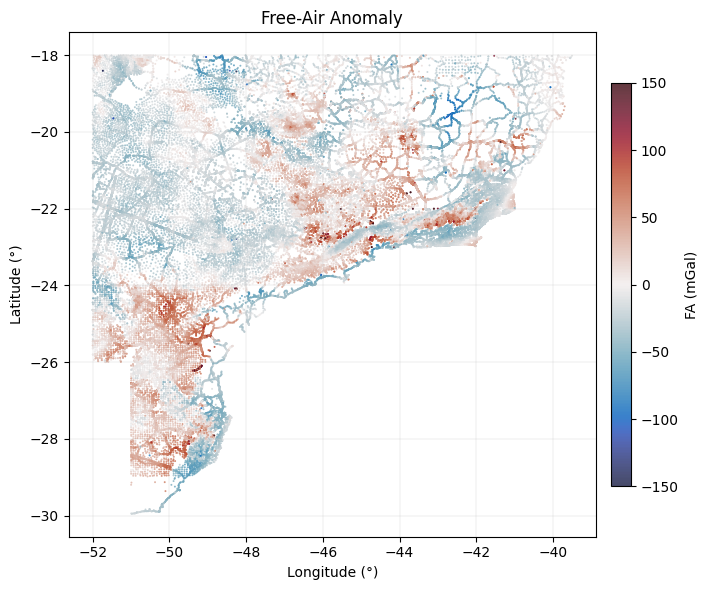

In [26]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(
    x, y,
    c=grav_gdf.loc[mask, 'FA'].values,
    cmap=cmocean.cm.balance,
    s=2,
    alpha=0.8,
    linewidth=0,
    vmin=-150,
    vmax=150
)

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("Free-Air Anomaly")

# Manter proporção ~ 1:1 nos eixos
ax.set_aspect("equal", adjustable="box")

# Barra de cores
cbar = fig.colorbar(sc, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label("FA (mGal)")

plt.grid(True, linewidth=0.3, alpha=0.5)
plt.tight_layout()

**Free-air para offshore de Sandwell et al. 2014 (atualizado até 2022)**

Download do arquivo .nc

In [27]:
import requests

url = "https://topex.ucsd.edu/pub/global_grav_1min/grav_32.1.nc"
filename = "grav_32.1.nc"

try:
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"Downloaded {filename} successfully.")

except requests.exceptions.RequestException as e:
    print(f"Error downloading {url}: {e}")

Downloaded grav_32.1.nc successfully.


Recorte na AOI

Variáveis disponíveis: ['z']
Bounds a partir dos dados de terra: -51.9998 -29.9529999999999 -39.50361111110002 -18.0
Pontos grav gerados: 537750


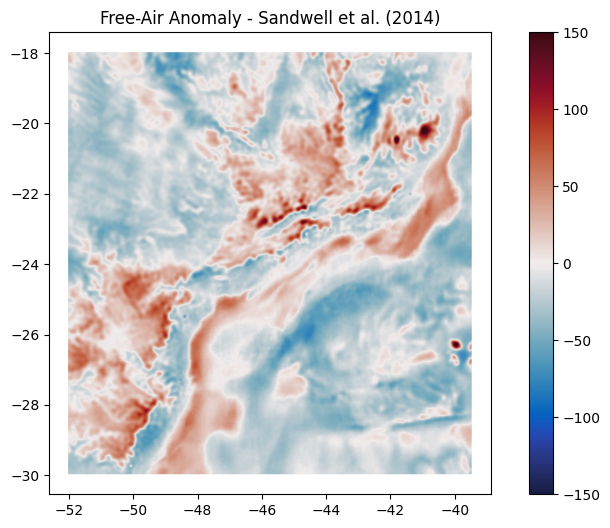

In [28]:
import xarray as xr

sandwell_ds = xr.open_dataset("/content/grav_32.1.nc")
# Tipicamente o dataset tem variáveis como 'lat', 'lon' e 'gravity'
print("Variáveis disponíveis:", list(sandwell_ds.data_vars))

minx, miny, maxx, maxy = grav_gdf_terra.total_bounds
print("Bounds a partir dos dados de terra:", minx, miny, maxx, maxy)

ds_sub = sandwell_ds.sel(
    lon=slice(minx, maxx),
    lat=slice(miny, maxy),
)

df = ds_sub["z"].to_dataframe(name="FA").reset_index()

# cria geometria
sandwell_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"
)

print("Pontos grav gerados:", len(sandwell_gdf))

fig, ax = plt.subplots(figsize=(10, 6))
sandwell_gdf.plot(ax=ax, column='FA', cmap=cmocean.cm.balance, legend=True, markersize=0.1, vmin=-150, vmax=150)
ax.set_title('Free-Air Anomaly - Sandwell et al. (2014)')
plt.show()


**Recorte para gravimetria offshore - Sandwell et al. 2014**

Obter batimetria de alta resolução

In [29]:
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import numpy as np
import pandas as pd

# Carregar CSV
df = pd.read_csv("/content/bat.csv")

# Criar GeoDataFrame com CRS da projeção policônica Sirgas 2000 (EPSG:5880)
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["X"], df["Y"]),
    crs="EPSG:5880"
)

# Definir resolução
res = 1000

# Limites da malha
minx, miny, maxx, maxy = gdf.total_bounds

# Calcular largura e altura do raster
width = int((maxx - minx) / res)
height = int((maxy - miny) / res)

# Definir a transformação affine
transform = from_origin(minx, maxy, res, res)

# Criar pares (geometria, valor)
shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf["BAT"]))

# Rasterizar
raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=np.nan,
    dtype="float32"
)

# Salvar GeoTIFF
with rasterio.open(
    "/content/bat_rasterized.tif",
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="float32",
    crs="EPSG:5880",
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(raster, 1)

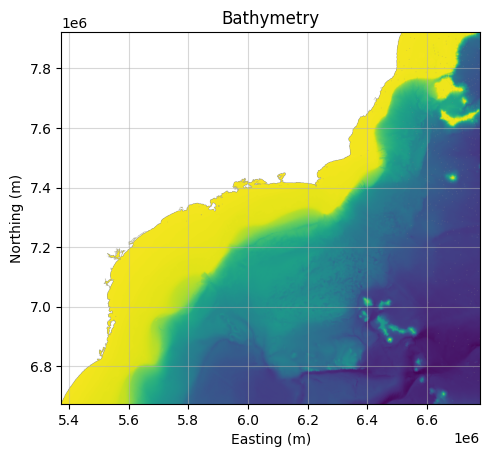

In [35]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Path to the rasterized bathymetry file
bat_rasterized_path = '/content/bat_rasterized.tif'

# Open the raster file
with rasterio.open(bat_rasterized_path) as src:
    # Read the raster data
    bat_data = src.read(1)
    # Get the transform
    transform = src.transform
    # Get the extent for plotting
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Plot the raster data
    fig, ax = plt.subplots(figsize=(5, 5))
    show(bat_data, ax=ax, transform=transform, extent=extent, cmap='viridis') # You can choose a different colormap

    ax.set_title('Bathymetry')
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

# Input raster path (original bat_rasterized.tif in EPSG:5880)
input_dem_path = '/content/bat_rasterized.tif'
# Output raster path (reprojected DEM in EPSG:4326)
reprojected_dem_path = '/content/bat_rasterized_4326.tif'

# Target CRS (matching grav_gdf and sandwell_gdf)
target_crs = 'EPSG:4326'

with rasterio.open(input_dem_path) as src:
    # Calculate the transform and dimensions of the reprojected raster
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds
    )

    # Define the metadata for the output raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Reproject and save the raster
    with rasterio.open(reprojected_dem_path, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest # Use nearest neighbor for discrete data, or cubic/bilinear for continuous
        )

print(f"Reprojected DEM saved to {reprojected_dem_path}")

# Update the dem_path variable to point to the reprojected file
dem_path = reprojected_dem_path

In [43]:
import geopandas as gpd
import rasterio
import numpy as np

dem_path = '/content/bat_rasterized.tif'

with rasterio.open(dem_path) as dem:
    # Reprojetar o GDF para o CRS do raster
    if sandwell_gdf.crs != dem.crs:
        sandwell_gdf_proj = sandwell_gdf.to_crs(dem.crs)
    else:
        sandwell_gdf_proj = sandwell_gdf

    # Criar lista de coordenadas no mesmo CRS do raster
    coords = [(pt.x, pt.y) for pt in sandwell_gdf_proj.geometry]

    # Amostrar o DEM nas coordenadas
    dem_vals = np.array([v[0] for v in dem.sample(coords)], dtype=np.float32)

    # Transformar nodata em NaN
    if dem.nodata is not None:
        dem_vals[dem_vals == dem.nodata] = np.nan

# Análises básicas
print("Valor mínimo do DEM:", np.nanmin(dem_vals))
print("Valor máximo do DEM:", np.nanmax(dem_vals))
print("Número de NaN no DEM:", np.isnan(dem_vals).sum())

# Filtrar onde DEM <= 0
offshore_mask = dem_vals <= 0
sandwell_offshore_gdf = sandwell_gdf.loc[offshore_mask].copy()  # manter CRS original
sandwell_offshore_gdf["BAT"] = dem_vals[offshore_mask]

# Comparação
print(f"Number of points in grav_gdf: {len(grav_gdf)}")
print(f"Number of points in sandwell_offshore_gdf: {len(sandwell_offshore_gdf)}")
print(grav_gdf.columns)
print(sandwell_offshore_gdf.columns)

Valor mínimo do DEM: -4650.1685
Valor máximo do DEM: 64.074295
Número de NaN no DEM: 314455
Number of points in grav_gdf: 237893
Number of points in sandwell_offshore_gdf: 222948
Index(['LATITUDE', 'LONGITUDE', 'GRAV_OBS', 'ALT_ORT', 'source_file',
       'ALT_ORTCO', 'geometry', 'FA_CORR', 'FA'],
      dtype='object')
Index(['lat', 'lon', 'FA', 'geometry', 'BAT'], dtype='object')


In [44]:
# Salvar backup
sandwell_offshore_gdf.to_file("/content/grav_fa_offshore.gpkg", driver="GPKG")
files.download('/content/grav_fa_offshore.gpkg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
display(grav_gdf_terra.head(3))
display(sandwell_offshore_gdf.head(3))

,LATITUDE,LONGITUDE,GRAV_OBS,ALT_ORTCO,FA_CORR,FA,geometry
1208,-26.726082,-49.484579,978933.06,518.086182,159.049316,16.983716,POINT (-49.48458 -26.72608)
1209,-26.733934,-49.478549,978933.21,522.671387,160.449524,17.966412,POINT (-49.47855 -26.73393)
1210,-26.744365,-49.478098,978934.66,520.868408,159.898941,18.111881,POINT (-49.4781 -26.74436)


,lat,lon,FA,geometry,BAT
114,-29.941667,-50.091667,-36.109917,POINT (-50.09167 -29.94167),-10.830011
115,-29.941667,-50.075000,-33.389019,POINT (-50.075 -29.94167),-16.026485
116,-29.941667,-50.058333,-28.891844,POINT (-50.05833 -29.94167),-19.073147
